In [1]:
from __future__ import print_function, division
import os,sys
import numpy as np
import torch # pytorch package, allows using GPUs
# fix seed
seed=17
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import datasets # load data
from torch.nn.utils.rnn import pad_sequence

all_data = 'ExpL project/MPSEQCN1.csv'
#all_data = 'ExpL project/MP_W_Seq.csv'
# Mapping for mechanical properties (assuming CSV columns [11,13,15,17] in this order)
target_property_index = {
    'toughness': 0,
    'youngs_modulus': 1,
    'tensile_strength': 2,
    'strain_at_break': 3
}
# Mapping: hydrophobicity, charge (pI), weights
aa_to_polarity = {
    'L': [3.80, 5.98, 113.084064015],   # Leucine
    'F': [2.80, 5.48, 147.068413945], # Phenylalanine
    'I': [4.50, 6.02, 113.084064015], # Isoleucine
    'C': [2.50, 5.07, 103.009184505],  # Cysteine
    'M': [1.90, 5.74, 131.040484645],  # Methionine
    'V': [4.20, 5.96, 99.068413945],  # Valine
    'W': [-0.9, 5.89, 186.079312980], # Tryptophan
    'Y': [-1.3, 5.66, 163.063328575], # Tyrosine
    'P': [-1.6, 6.30, 97.052763875],  # Proline
    'A': [1.80, 6.00, 71.037113805], # Alanine
    'T': [-0.7, 5.60, 101.047678505], # Threonine
    'G': [-0.4, 5.97, 57.021463735], # Glycine
    'S': [-0.8, 5.68, 87.032028435], # Serine
    'H': [-3.2, 7.59, 137.058911875], # Histidine
    'Q': [-3.5, 5.65, 128.058577540], # Glutamine
    'R': [-4.5, 10.76, 156.101111050], # Arginine
    'K': [-3.9, 9.74, 128.094963050], # Lysine
    'N': [-3.5, 5.41, 114.042927470], # Asparagine
    'E': [-3.5, 3.22, 129.042593135], # Glutamic acid
    'D': [-3.5, 2.77, 115.026943065]  # Aspartic acid
}
# Reverse mapping to decode numbers back into amino acids.
polarity_to_aa = {tuple(v): k for k, v in aa_to_polarity.items()}
def sequence_to_polarity_numbers(seq, mapping=aa_to_polarity):
    """
    Convert an amino acid sequence to a list of unique integer values based on polarity.
    Amino acids not in the mapping will be assigned 0.
    """
    default_vector = [0.0, 0.0, 0.0]
    return [mapping.get(aa, default_vector) for aa in seq]

In [3]:
import argparse
import sys; sys.argv=['']; del sys  # for Jupyter notebooks

parser = argparse.ArgumentParser(
    description='PyTorch Regression Model: Predict a Mechanical Property from AA Sequences')
# ... (other arguments)
parser.add_argument('--target-property', type=str, choices=['toughness', 'youngs_modulus', 'tensile_strength', 'strain_at_break'],
                    default='toughness', help='Mechanical property to predict')
# example values for other arguments:
parser.add_argument('--batch-size', type=int, default=32, metavar='N', help='Training batch size (default: 32)')
parser.add_argument('--test-batch-size', type=int, default=64, metavar='N', help='Test batch size (default: 64)')
parser.add_argument('--epochs', type=int, default=5, metavar='N', help='Number of epochs (default: 5)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR', help='Learning rate (0.0001)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M', help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False, help='Disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S', help='Random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=1, metavar='N', help='Batches between logging (default: 1)')
args = parser.parse_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
print("Arguments:", args)


Arguments: Namespace(target_property='toughness', batch_size=32, test_batch_size=64, epochs=5, lr=0.01, momentum=0.5, no_cuda=False, seed=1, log_interval=1, cuda=False)


In [4]:
class Silkome_Dataset(Dataset):
    """Silkome pytorch dataset for the mechanical properties and amino acid sequences.
     Assumes:
      - uses a CSV file where:
          - index 0: Individual IDs.
          - indexes 11, 13, 15, 17: Mechanical properties 
            (in order: "toughness", "youngs_modulus", "tensile_strength", "strain_at_break").
          - index 21: Amino acid sequences concatenated from two columns.
            (Sequences are assumed to be separated by a comma ',')
      - Each cell in the sequence column must contain at least one sequence.
      - Maximum number of sequences per cell is 2.
      - Each sequence must have a length between 151 and 1515.
    """

    def __init__(self, all_data, data_type='train', transform=None, test_size=0.2, random_state=42):
        """
       Args:
            all_data (str): Path to the CSV file. (ExpL project/MP_W_Seq.csv)
            data_type (str): 'train' or 'test'. Use 'train' for the training set and 'test' for the testing set.
            transform (callable, optional): Optional transform to be applied on a sample.
            test_size (float): Fraction of data to use as test set.
            random_state (int): Seed for splitting.
        """
        self.df = pd.read_csv(all_data)
        
        # Extract individual IDs from column 0
        self.ids = self.df.iloc[:, 0].values

        # Extract mechanical properties from columns 11, 13, 15, 17
        self.mechanical_props = self.df.iloc[:, [11, 13, 15, 17]].values.astype(np.float32)

        # Process the amino acid sequences from column 21.
        # First, fill missing values (if any) with an empty string.
        raw_sequences = self.df["MaSp1"].fillna('').values

        processed_sequences = []
        polarity_numeric_sequences = []  # Store numeric representations based on polarity.
        for i, s in enumerate(raw_sequences):
            # Split on comma; adjust the delimiter if needed.
            seq_list = [seq.strip() for seq in s.split(',') if seq.strip() != '']
            
            # Filter each sequence by length (151 to 1515 AAs)
            valid_seqs = [seq for seq in seq_list if 151 <= len(seq) <= 1515]
            #print (valid_seqs)
            
            processed_sequences.append(valid_seqs)
            
            # Convert each valid sequence to its numeric representation based on polarity.
            numeric_seq_list = [sequence_to_polarity_numbers(seq) for seq in valid_seqs]
            polarity_numeric_sequences.append(numeric_seq_list)
        #print("Length of IDs:", len(self.ids))
        #print("Length of processed sequences:", len(processed_sequences))
        #print("DataFrame shape:", self.df.shape)
        #print("Columns:", self.df.columns)
        #print("Raw sequences array length:", len(raw_sequences))
        #print("First few raw sequences:", raw_sequences[:5])

        
        self.sequences = processed_sequences
        self.polarity_numeric_sequences = polarity_numeric_sequences
        
        #train/test split
        if data_type in ['train', 'test']:
            indices = np.arange(len(self.ids))
            train_idx, test_idx = train_test_split(indices, test_size=test_size, random_state=random_state)
            if data_type == 'train':
                sel = train_idx
                print("Using training set (80% of data)")
            else:
                sel = test_idx
                print("Using testing set (20% of data)")
            
            self.ids = self.ids[sel]
            self.mechanical_props = self.mechanical_props[sel]
            self.sequences = [self.sequences[i] for i in sel]
            self.polarity_numeric_sequences = [self.polarity_numeric_sequences[i] for i in sel]
        
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        sample = {
            'id': self.ids[idx],
            'mechanical_props': self.mechanical_props[idx],  # ex, a numpy array of shape (4,)
            #'sequences': self.sequences[idx],  # list of one to eight sequences (strings)
            'polarity_numeric_sequences': self.polarity_numeric_sequences[idx]
        }
        if self.transform:
            sample = self.transform(sample)
        return sample

def custom_collate(batch):
    """
    Converts a batch from the dataset (with keys:
      - 'id'
      - 'mechanical_props': vector of 4 values per sample
      - 'polarity_numeric_sequences': list of sequences (each a list of ints)
    )
    into a dictionary with keys:
      - 'sequence': a padded LongTensor of shape (batch, max_len) using the first sequence.
      - 'mechanical_input': auxiliary mechanical input (can be chosen as needed).
      - 'target': the chosen mechanical property to predict.
    """
    import torch
    batch_ids = [item['id'] for item in batch]
    batch_mech = torch.stack([torch.tensor(item['mechanical_props']) for item in batch])
    
    # Select the target property using the index from mapping.
    target_idx = target_property_index[args.target_property]
    batch_target = batch_mech[:, target_idx].unsqueeze(1)
    
    # For the sequence, take the first available numeric sequence from each sample.
    batch_sequence = [
        item['polarity_numeric_sequences'][0] if len(item['polarity_numeric_sequences']) > 0 else []
        for item in batch
    ]
    
    max_len = 200  # Fixed padded sequence length
    feature_dim = 3 #3 features per amino acid
    padded_sequences = []
    for seq in batch_sequence:
        # If the sequence is not empty and its first element is not a list, assume it's 1D.
        if len(seq) > 0 and not isinstance(seq[0], (list, tuple)):
            # Convert each scalar token into a list of 3 elements.
            # Here we replicate the scalar in the first slot and fill the remaining with 0.0.
            seq = [[token, 0.0, 0.0] for token in seq]
        
        # Now convert to tensor.
        seq_tensor = torch.tensor(seq, dtype=torch.float)  # Expected shape: (seq_length, feature_dim)
        # Pad or truncate to max_len.
        current_len = seq_tensor.size(0)
        if current_len < max_len:
            pad = torch.zeros((max_len - current_len, feature_dim), dtype=torch.float)
            padded_seq = torch.cat([seq_tensor, pad], dim=0)
        else:
            padded_seq = seq_tensor[:max_len, :]
        padded_sequences.append(padded_seq)
    
    batch_sequence_tensor = torch.stack(padded_sequences)  # shape: (batch, max_len, feature_dim)
    
    # Choose auxiliary mechanical input, e.g. the second property.
    auxiliary_idx = 0
    batch_mechanical_input = batch_mech[:, auxiliary_idx].unsqueeze(1)
    
    return {
        'id': batch_ids,
        'sequence': batch_sequence_tensor,
        'mechanical_input': batch_mechanical_input,
        'target': batch_target
    }

def load_data(all_data, batch_size, test_batch_size, **kwargs):
    """
    Create PyTorch DataLoaders for training and testing from the CSV file.
    
    Args:
        all_data (str): Path to the CSV file.
        batch_size (int): Batch size for the training loader.
        test_batch_size (int): Batch size for the test loader.
        **kwargs: Additional arguments for DataLoader (e.g., num_workers, pin_memory).
    
    Returns:
        train_loader, test_loader: DataLoader objects.
    """
    train_dataset = Silkome_Dataset(all_data=all_data, data_type='train')
    test_dataset = Silkome_Dataset(all_data=all_data, data_type='test')
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                              collate_fn=custom_collate, **kwargs)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, 
                             collate_fn=custom_collate, **kwargs)

    
    return train_loader, test_loader

# Example usage:
if __name__ == "__main__":
    csv_path = 'ExpL project/MPSEQCN1.csv'
    train_loader, test_loader = load_data(csv_path, batch_size=32, test_batch_size=32)
    
    # Iterate through one batch from the training loader and print a sample
    for batch in train_loader:
        print("IDs:", batch['id'])
        print("Mechanical properties:", batch['mechanical_input'])
        print("Sequences:", batch['sequence'])
        break

Using training set (80% of data)
Using testing set (20% of data)
IDs: [6019, 3883, 4007, 7303, 5239, 5104, 6713, 2801, 2156, 6755, 4910, 5337, 5804, 6748, 3899, 3393, 1894, 3819, 5118, 2664, 6329, 2158, 6266, 4542, 5219, 5457, 3469, 5290, 7302, 6795, 5249, 3793]
Mechanical properties: tensor([[0.1020],
        [0.1390],
        [0.0500],
        [0.1810],
        [0.1050],
        [0.1530],
        [0.2730],
        [0.1140],
        [0.1090],
        [0.1350],
        [0.1260],
        [0.1040],
        [0.0420],
        [0.1230],
        [0.0460],
        [0.0770],
        [0.0500],
        [0.1120],
        [0.0340],
        [0.1980],
        [0.0770],
        [0.0820],
        [0.1310],
        [0.0400],
        [0.1020],
        [0.0500],
        [0.0530],
        [0.1670],
        [0.2500],
        [0.1610],
        [0.1280],
        [0.3100]])
Sequences: tensor([[[ -3.5000,   5.6500, 128.0586],
         [ -0.4000,   5.9700,  57.0215],
         [ -0.4000,   5.9700,  57.0215],
   

Defining the Neural Network and its Architecture

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, vocab_size=21, max_len=200, feature_dim=3,
                 conv_out_channels=64, hidden_dim_seq=128, hidden_dim_combined=64):
        """
        Args:
            vocab_size (int): Number of unique tokens (e.g. 21 if you map AAs 1-20, 0 for padding).
            embedding_dim (int): Dimension of the embedding vectors.
            max_len (int): Fixed length for padded amino acid sequences.
            conv_out_channels (int): Number of output channels for the 1D convolution.
            feature_dim (int): Number of features per amino acid (e.g., 3 for hydrophobicity, charge, weight).
            hidden_dim_seq (int): Size of the intermediate representation from the sequence branch.
            hidden_dim_combined (int): Size of the combined hidden layer.
            
        The model processes a padded, numeric sequence (shape: [batch, max_len]) and 
        a mechanical property input (shape: [batch, 1]) and outputs a single continuous prediction.
        """
        super(Model, self).__init__()
        # Embedding layer to convert token indices to embeddings.
        #self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=0)
        
        # 1D Convolution over the sequence dimension.
        self.conv1 = nn.Conv1d(in_channels=feature_dim, out_channels=conv_out_channels,
                               kernel_size=3, padding=1)
        # 1D max pooling to reduce sequence length.
        self.pool = nn.MaxPool1d(kernel_size=2)
        
        # Calculate the pooled sequence length.
        pooled_len = max_len // 2  # This assumes max_len is even.
        
        # Fully connected layer to obtain a fixed-length representation from the sequence.
        self.fc_seq = nn.Linear(conv_out_channels * pooled_len, hidden_dim_seq)
        
        # Fully connected layer to combine the sequence representation and mechanical input.
        self.fc_combined = nn.Linear(hidden_dim_seq + 1, hidden_dim_combined)
        
        # Output layer: predict one continuous value (the target mechanical property).
        self.fc_out = nn.Linear(hidden_dim_combined, 1)
        
    def forward(self, sample):
        """
        Args:
            sample (dict): Should contain:
                - 'sequence': Long tensor of shape (batch, max_len) containing the padded, numerically encoded sequence.
                - 'mechanical_input': Tensor of shape (batch, 1) with the extra mechanical property.
                
        Returns:
            Tensor of shape (batch, 1) with the predicted continuous value.
        """
        # Extract inputs.
        seq = sample['sequence']           # shape: (batch, max_len)
        mech = sample['mechanical_input']  # shape: (batch, 1)
        print("Input sequence shape:", seq.shape)
        print("Input mechanical shape:", mech.shape)
        # Process the sequence.
        # Embedding: (batch, max_len) --> (batch, max_len, embedding_dim)
        #x = self.embedding(seq)
        #print("After embedding:", x.shape)
        # Permute to shape: (batch, embedding_dim, max_len) for convolution.
        x = seq
        x = x.permute(0, 2, 1)
        print("After permute:", x.shape)
        # Convolution and ReLU activation.
        x = F.relu(self.conv1(x))
        print("After conv1:", x.shape)
        # Max pooling reduces the sequence length.
        x = self.pool(x)  # shape: (batch, conv_out_channels, max_len//2)
        print("After pooling:", x.shape)
        # Flatten the convolution output.
        x = x.view(x.size(0), -1)
        print("After flattening:", x.shape)
        # Fully connected layer to obtain sequence representation.
        x_seq = F.relu(self.fc_seq(x))
        print("After fc_seq:", x_seq.shape)
        
        # Concatenate the sequence representation with the mechanical property.
        x_comb = torch.cat([x_seq, mech], dim=1)
        print("After concatenation:", x_comb.shape)
        x_comb = F.relu(self.fc_combined(x_comb))
        print("After fc_combined:", x_comb.shape)
        output = self.fc_out(x_comb)
        print("Final output shape:", output.shape)
        return output

# Example usage:
if __name__ == "__main__":
    # Instantiate the model.
    # Here we use a smaller max_len for demonstration purposes.
    model = Model(vocab_size=21, max_len=200, feature_dim=3,
                  conv_out_channels=64, hidden_dim_seq=128, hidden_dim_combined=64)
    
    # Dummy input:
   # Create a dummy input with shape: (batch_size, max_len, feature_dim)
    dummy_sequence = torch.randn(32, 200, 3)  # For example, random features
    dummy_mechanical = torch.randn(32, 1)       # Auxiliary mechanical input
    dummy_input = {'sequence': dummy_sequence, 'mechanical_input': dummy_mechanical}

    
    # Get predictions.
    predictions = model(dummy_input)
    print("Predictions shape:", predictions.shape)  # Expected shape: (32, 1)


Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 64, 200])
After pooling: torch.Size([32, 64, 100])
After flattening: torch.Size([32, 6400])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Predictions shape: torch.Size([32, 1])


In [6]:
from tqdm import tqdm
def train(epoch):
    model.train()  # Set model to training mode (affects Dropout, BatchNorm, etc.)
    for batch_idx, sample in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}")):
        # Move each tensor in the sample dictionary to GPU if needed.
        if args.cuda:
            sample = {key: value.cuda() if isinstance(value, torch.Tensor) else value 
                      for key, value in sample.items()}
        
        optimizer.zero_grad()
        output = model(sample)  # The model expects a dictionary input.
        
        # Compute the mean squared error between predictions and target values.
        loss = F.mse_loss(output, sample['target'])
        loss.backward()
        optimizer.step()
        
        if batch_idx % args.log_interval == 0:
            # Here, sample['target'] is assumed to be of shape (batch_size, 1)
            processed = batch_idx * sample['target'].size(0)
            total = len(train_loader.dataset)
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, processed, total,
                100. * batch_idx / len(train_loader), loss.item()))

def test(data_loader, verbose='Test'):
    model.eval()  # Set model to evaluation mode.
    test_loss = 0
    with torch.no_grad():
        for sample in data_loader:
            if args.cuda:
                sample = {key: value.cuda() if isinstance(value, torch.Tensor) else value 
                          for key, value in sample.items()}
            output = model(sample)
            # Sum the MSE loss over the batch.
            test_loss += F.mse_loss(output, sample['target'], reduction='sum').item()
    
    test_loss /= len(data_loader.dataset)
    print('\n{} set: Average loss: {:.4f}\n'.format(verbose, test_loss))
    return test_loss


In [64]:
import torch.nn.functional as F
import torch.optim as optim

# load data using your load_data function (which already applies custom_collate)
train_loader, test_loader = load_data(all_data, batch_size=args.batch_size, test_batch_size=args.test_batch_size)

test_array = []

# We will vary the convolutional layer's depth (conv_out_channels) with values from N_array.
N_array = [1, 5, 10, 20, 50]

for N in N_array:
    # Instantiate the regression model.
    # Here, max_len is the fixed padded length for your sequence,
    # vocab_size=21 assumes tokens 1-20 for amino acids (0 used for padding).
    model = Model(vocab_size=21, max_len=200, feature_dim=3,
                  conv_out_channels=N, hidden_dim_seq=128, hidden_dim_combined=64)
    if args.cuda:
        model = model.cuda()

    # For regression, we'll use MSE loss inside the train/test functions.
    optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=args.momentum)
    
    # Train the model for a fixed number of epochs.
    for epoch in range(1, args.epochs + 1):
        train(epoch)  # Your train() function should use `model` and `optimizer`
        
        # At the final epoch, store the test losses.
        if epoch == args.epochs:
            test_loss = test(test_loader, verbose='Test')
            test_array.append(test_loss)
    
    print("For conv_out_channels =", N)
    print("Test losses:", test_array)

Using training set (80% of data)
Using testing set (20% of data)


Epoch 1:  80%|████████  | 4/5 [00:00<00:00, 36.36it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 1, 200])
After pooling: torch.Size([32, 1, 100])
After flattening: torch.Size([32, 100])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 1 [0/140 (0%)]	Loss: 21.328369
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 1, 200])
After pooling: torch.Size([32, 1, 100])
After flattening: torch.Size([32, 100])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 1 [32/140 (20%)]	Loss: 20.033833
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
Aft

Epoch 2:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 1, 200])
After pooling: torch.Size([32, 1, 100])
After flattening: torch.Size([32, 100])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 2 [0/140 (0%)]	Loss: 18.689533
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 1, 200])
After pooling: torch.Size([32, 1, 100])
After flattening: torch.Size([32, 100])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 2 [32/140 (20%)]	Loss: 14.920941
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
Aft

Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 45.86it/s]


Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
After permute: torch.Size([12, 3, 200])
After conv1: torch.Size([12, 1, 200])
After pooling: torch.Size([12, 1, 100])
After flattening: torch.Size([12, 100])
After fc_seq: torch.Size([12, 128])
After concatenation: torch.Size([12, 129])
After fc_combined: torch.Size([12, 64])
Final output shape: torch.Size([12, 1])
Train Epoch: 2 [48/140 (80%)]	Loss: 14.209704


Epoch 3:  80%|████████  | 4/5 [00:00<00:00, 37.73it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 1, 200])
After pooling: torch.Size([32, 1, 100])
After flattening: torch.Size([32, 100])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 3 [0/140 (0%)]	Loss: 12.885727
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 1, 200])
After pooling: torch.Size([32, 1, 100])
After flattening: torch.Size([32, 100])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 3 [32/140 (20%)]	Loss: 12.060278
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
Aft

Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 39.66it/s]


Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
After permute: torch.Size([12, 3, 200])
After conv1: torch.Size([12, 1, 200])
After pooling: torch.Size([12, 1, 100])
After flattening: torch.Size([12, 100])
After fc_seq: torch.Size([12, 128])
After concatenation: torch.Size([12, 129])
After fc_combined: torch.Size([12, 64])
Final output shape: torch.Size([12, 1])
Train Epoch: 3 [48/140 (80%)]	Loss: 11.575465


Epoch 4:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 1, 200])
After pooling: torch.Size([32, 1, 100])
After flattening: torch.Size([32, 100])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 4 [0/140 (0%)]	Loss: 10.672510
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 1, 200])
After pooling: torch.Size([32, 1, 100])
After flattening: torch.Size([32, 100])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 4 [32/140 (20%)]	Loss: 8.883783
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
Afte

Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 41.53it/s]


Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 1, 200])
After pooling: torch.Size([32, 1, 100])
After flattening: torch.Size([32, 100])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 4 [96/140 (60%)]	Loss: 8.410803
Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
After permute: torch.Size([12, 3, 200])
After conv1: torch.Size([12, 1, 200])
After pooling: torch.Size([12, 1, 100])
After flattening: torch.Size([12, 100])
After fc_seq: torch.Size([12, 128])
After concatenation: torch.Size([12, 129])
After fc_combined: torch.Size([12, 64])
Final output shape: torch.Size([12, 1])
Train Epoch: 4 [48/140 (80%)]	Loss: 7.799053


Epoch 5:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 1, 200])
After pooling: torch.Size([32, 1, 100])
After flattening: torch.Size([32, 100])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 5 [0/140 (0%)]	Loss: 8.329038
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 1, 200])
After pooling: torch.Size([32, 1, 100])
After flattening: torch.Size([32, 100])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 5 [32/140 (20%)]	Loss: 7.558156


Epoch 5:  80%|████████  | 4/5 [00:00<00:00, 38.63it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 1, 200])
After pooling: torch.Size([32, 1, 100])
After flattening: torch.Size([32, 100])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 5 [64/140 (40%)]	Loss: 6.847098
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 1, 200])
After pooling: torch.Size([32, 1, 100])
After flattening: torch.Size([32, 100])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 5 [96/140 (60%)]	Loss: 6.505662


Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 41.61it/s]


Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
After permute: torch.Size([12, 3, 200])
After conv1: torch.Size([12, 1, 200])
After pooling: torch.Size([12, 1, 100])
After flattening: torch.Size([12, 100])
After fc_seq: torch.Size([12, 128])
After concatenation: torch.Size([12, 129])
After fc_combined: torch.Size([12, 64])
Final output shape: torch.Size([12, 1])
Train Epoch: 5 [48/140 (80%)]	Loss: 7.125730
Input sequence shape: torch.Size([36, 200, 3])
Input mechanical shape: torch.Size([36, 1])
After permute: torch.Size([36, 3, 200])
After conv1: torch.Size([36, 1, 200])
After pooling: torch.Size([36, 1, 100])
After flattening: torch.Size([36, 100])
After fc_seq: torch.Size([36, 128])
After concatenation: torch.Size([36, 129])
After fc_combined: torch.Size([36, 64])
Final output shape: torch.Size([36, 1])

Test set: Average loss: 5.8308

For conv_out_channels = 1
Test losses: [5.8308084275987415]


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 3, 200])
After pooling: torch.Size([32, 3, 100])
After flattening: torch.Size([32, 300])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 1 [0/140 (0%)]	Loss: 0.315643
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 3, 200])
After pooling: torch.Size([32, 3, 100])
After flattening: torch.Size([32, 300])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])


Epoch 1:  80%|████████  | 4/5 [00:00<00:00, 37.15it/s]

Train Epoch: 1 [32/140 (20%)]	Loss: 0.223540
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 3, 200])
After pooling: torch.Size([32, 3, 100])
After flattening: torch.Size([32, 300])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 1 [64/140 (40%)]	Loss: 0.206603
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 3, 200])
After pooling: torch.Size([32, 3, 100])
After flattening: torch.Size([32, 300])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 1 [96/140 (60%)]	Loss: 0.229066


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 40.95it/s]


Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
After permute: torch.Size([12, 3, 200])
After conv1: torch.Size([12, 3, 200])
After pooling: torch.Size([12, 3, 100])
After flattening: torch.Size([12, 300])
After fc_seq: torch.Size([12, 128])
After concatenation: torch.Size([12, 129])
After fc_combined: torch.Size([12, 64])
Final output shape: torch.Size([12, 1])
Train Epoch: 1 [48/140 (80%)]	Loss: 0.312339


Epoch 2:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])


Epoch 2:  80%|████████  | 4/5 [00:00<00:00, 38.92it/s]

After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 3, 200])
After pooling: torch.Size([32, 3, 100])
After flattening: torch.Size([32, 300])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 2 [0/140 (0%)]	Loss: 0.278127
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 3, 200])
After pooling: torch.Size([32, 3, 100])
After flattening: torch.Size([32, 300])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 2 [32/140 (20%)]	Loss: 0.181548
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 3, 200])
After pooling: tor

Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 42.67it/s]


After permute: torch.Size([12, 3, 200])
After conv1: torch.Size([12, 3, 200])
After pooling: torch.Size([12, 3, 100])
After flattening: torch.Size([12, 300])
After fc_seq: torch.Size([12, 128])
After concatenation: torch.Size([12, 129])
After fc_combined: torch.Size([12, 64])
Final output shape: torch.Size([12, 1])
Train Epoch: 2 [48/140 (80%)]	Loss: 0.271688


Epoch 3:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 3, 200])
After pooling: torch.Size([32, 3, 100])
After flattening: torch.Size([32, 300])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 3 [0/140 (0%)]	Loss: 0.225461
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 3, 200])
After pooling: torch.Size([32, 3, 100])
After flattening: torch.Size([32, 300])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 3 [32/140 (20%)]	Loss: 0.250918


Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 45.23it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 3, 200])
After pooling: torch.Size([32, 3, 100])
After flattening: torch.Size([32, 300])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 3 [64/140 (40%)]	Loss: 0.261804
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 3, 200])
After pooling: torch.Size([32, 3, 100])
After flattening: torch.Size([32, 300])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 3 [96/140 (60%)]	Loss: 0.243942
Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
Aft

Epoch 4:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 3, 200])
After pooling: torch.Size([32, 3, 100])
After flattening: torch.Size([32, 300])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 4 [0/140 (0%)]	Loss: 0.236001
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 3, 200])
After pooling: torch.Size([32, 3, 100])
After flattening: torch.Size([32, 300])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 4 [32/140 (20%)]	Loss: 0.245730


Epoch 4:  80%|████████  | 4/5 [00:00<00:00, 39.99it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 3, 200])
After pooling: torch.Size([32, 3, 100])
After flattening: torch.Size([32, 300])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 4 [64/140 (40%)]	Loss: 0.224986
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 3, 200])
After pooling: torch.Size([32, 3, 100])
After flattening: torch.Size([32, 300])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 4 [96/140 (60%)]	Loss: 0.274482


Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 42.72it/s]


Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
After permute: torch.Size([12, 3, 200])
After conv1: torch.Size([12, 3, 200])
After pooling: torch.Size([12, 3, 100])
After flattening: torch.Size([12, 300])
After fc_seq: torch.Size([12, 128])
After concatenation: torch.Size([12, 129])
After fc_combined: torch.Size([12, 64])
Final output shape: torch.Size([12, 1])
Train Epoch: 4 [48/140 (80%)]	Loss: 0.204313


Epoch 5:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 3, 200])
After pooling: torch.Size([32, 3, 100])
After flattening: torch.Size([32, 300])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 5 [0/140 (0%)]	Loss: 0.242796
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 3, 200])
After pooling: torch.Size([32, 3, 100])
After flattening: torch.Size([32, 300])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 5 [32/140 (20%)]	Loss: 0.231820
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After

Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 41.86it/s]


Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 3, 200])
After pooling: torch.Size([32, 3, 100])
After flattening: torch.Size([32, 300])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 5 [96/140 (60%)]	Loss: 0.215078
Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
After permute: torch.Size([12, 3, 200])
After conv1: torch.Size([12, 3, 200])
After pooling: torch.Size([12, 3, 100])
After flattening: torch.Size([12, 300])
After fc_seq: torch.Size([12, 128])
After concatenation: torch.Size([12, 129])
After fc_combined: torch.Size([12, 64])
Final output shape: torch.Size([12, 1])
Train Epoch: 5 [48/140 (80%)]	Loss: 0.235530
Input sequence shape: torch.Size([36, 200, 3])
Input mechanical shape: torch.Size([36, 1])
Aft

Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 5, 200])
After pooling: torch.Size([32, 5, 100])
After flattening: torch.Size([32, 500])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 1 [0/140 (0%)]	Loss: 0.486715
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 5, 200])
After pooling:

Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 42.08it/s]


 torch.Size([32, 5, 100])
After flattening: torch.Size([32, 500])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 1 [32/140 (20%)]	Loss: 0.710768
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 5, 200])
After pooling: torch.Size([32, 5, 100])
After flattening: torch.Size([32, 500])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 1 [64/140 (40%)]	Loss: 0.560478
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 5, 200])
After pooling: torch.Size([32, 5, 100])
After flattening: torch.Size([32, 500])
After fc_seq: torch.Size([32

Epoch 2:  80%|████████  | 4/5 [00:00<00:00, 37.51it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 5, 200])
After pooling: torch.Size([32, 5, 100])
After flattening: torch.Size([32, 500])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 2 [0/140 (0%)]	Loss: 0.545211
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 5, 200])
After pooling: torch.Size([32, 5, 100])
After flattening: torch.Size([32, 500])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 2 [32/140 (20%)]	Loss: 0.760691
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After

Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 40.28it/s]


Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
After permute: torch.Size([12, 3, 200])
After conv1: torch.Size([12, 5, 200])
After pooling: torch.Size([12, 5, 100])
After flattening: torch.Size([12, 500])
After fc_seq: torch.Size([12, 128])
After concatenation: torch.Size([12, 129])
After fc_combined: torch.Size([12, 64])
Final output shape: torch.Size([12, 1])
Train Epoch: 2 [48/140 (80%)]	Loss: 0.525926


Epoch 3:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 5, 200])
After pooling: torch.Size([32, 5, 100])
After flattening: torch.Size([32, 500])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 3 [0/140 (0%)]	Loss: 0.539613
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 5, 200])
After pooling: torch.Size([32, 5, 100])
After flattening: torch.Size([32, 500])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 3 [32/140 (20%)]	Loss: 0.676431
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After

Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 41.27it/s]


Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 5, 200])
After pooling: torch.Size([32, 5, 100])
After flattening: torch.Size([32, 500])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 3 [96/140 (60%)]	Loss: 0.516136
Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
After permute: torch.Size([12, 3, 200])
After conv1: torch.Size([12, 5, 200])
After pooling: torch.Size([12, 5, 100])
After flattening: torch.Size([12, 500])
After fc_seq: torch.Size([12, 128])
After concatenation: torch.Size([12, 129])
After fc_combined: torch.Size([12, 64])
Final output shape: torch.Size([12, 1])
Train Epoch: 3 [48/140 (80%)]	Loss: 0.460637


Epoch 4:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 5, 200])
After pooling: torch.Size([32, 5, 100])
After flattening: torch.Size([32, 500])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 4 [0/140 (0%)]	Loss: 0.667246
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 5, 200])
After pooling: torch.Size([32, 5, 100])
After flattening: torch.Size([32, 500])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 4 [32/140 (20%)]	Loss: 0.429983


Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 42.07it/s]


Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 5, 200])
After pooling: torch.Size([32, 5, 100])
After flattening: torch.Size([32, 500])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 4 [64/140 (40%)]	Loss: 0.753774
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 5, 200])
After pooling: torch.Size([32, 5, 100])
After flattening: torch.Size([32, 500])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 4 [96/140 (60%)]	Loss: 0.592212
Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
Aft

Epoch 5:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 5, 200])
After pooling: torch.Size([32, 5, 100])
After flattening: torch.Size([32, 500])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 5 [0/140 (0%)]	Loss: 0.474572
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 5, 200])
After pooling: torch.Size([32, 5, 100])
After flattening: torch.Size([32, 500])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 5 [32/140 (20%)]	Loss: 0.671887


Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 36.57it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 5, 200])
After pooling: torch.Size([32, 5, 100])
After flattening: torch.Size([32, 500])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 5 [64/140 (40%)]	Loss: 0.712330
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 5, 200])
After pooling: torch.Size([32, 5, 100])
After flattening: torch.Size([32, 500])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 5 [96/140 (60%)]	Loss: 0.475402
Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
Aft

Input sequence shape: torch.Size([36, 200, 3])
Input mechanical shape: torch.Size([36, 1])
After permute: torch.Size([36, 3, 200])
After conv1: torch.Size([36, 5, 200])
After pooling: torch.Size([36, 5, 100])
After flattening: torch.Size([36, 500])
After fc_seq: torch.Size([36, 128])
After concatenation: torch.Size([36, 129])
After fc_combined: torch.Size([36, 64])
Final output shape: torch.Size([36, 1])

Test set: Average loss: 0.7252

For conv_out_channels = 5
Test losses: [5.8308084275987415, 0.21913891368442112, 0.7251860300699869]


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 8, 200])
After pooling: torch.Size([32, 8, 100])
After flattening: torch.Size([32, 800])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 1 [0/140 (0%)]	Loss: 0.043348
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 8, 200])
After pooling: torch.Size([32, 8, 100])
After flattening: torch.Size([32, 800])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 1 [32/140 (20%)]	Loss: 0.048694


Epoch 1:  80%|████████  | 4/5 [00:00<00:00, 37.81it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 8, 200])
After pooling: torch.Size([32, 8, 100])
After flattening: torch.Size([32, 800])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 1 [64/140 (40%)]	Loss: 0.052355
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 8, 200])
After pooling: torch.Size([32, 8, 100])
After flattening: torch.Size([32, 800])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 1 [96/140 (60%)]	Loss: 0.064841


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 41.17it/s]


Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
After permute: torch.Size([12, 3, 200])
After conv1: torch.Size([12, 8, 200])
After pooling: torch.Size([12, 8, 100])
After flattening: torch.Size([12, 800])
After fc_seq: torch.Size([12, 128])
After concatenation: torch.Size([12, 129])
After fc_combined: torch.Size([12, 64])
Final output shape: torch.Size([12, 1])
Train Epoch: 1 [48/140 (80%)]	Loss: 0.141487


Epoch 2:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 8, 200])
After pooling: torch.Size([32, 8, 100])
After flattening: torch.Size([32, 800])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 2 [0/140 (0%)]	Loss: 0.084310
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 8, 200])
After pooling: torch.Size([32, 8, 100])
After flattening: torch.Size([32, 800])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 2 [32/140 (20%)]	Loss: 0.060033
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After

Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 44.02it/s]


Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
After permute: torch.Size([12, 3, 200])
After conv1: torch.Size([12, 8, 200])
After pooling: torch.Size([12, 8, 100])
After flattening: torch.Size([12, 800])
After fc_seq: torch.Size([12, 128])
After concatenation: torch.Size([12, 129])
After fc_combined: torch.Size([12, 64])
Final output shape: torch.Size([12, 1])
Train Epoch: 2 [48/140 (80%)]	Loss: 0.058356


Epoch 3:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 8, 200])
After pooling: torch.Size([32, 8, 100])
After flattening: torch.Size([32, 800])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 3 [0/140 (0%)]	Loss: 0.080415
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 8, 200])
After pooling: torch.Size([32, 8, 100])
After flattening: torch.Size([32, 800])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 3 [32/140 (20%)]	Loss: 0.051573


Epoch 3:  80%|████████  | 4/5 [00:00<00:00, 38.56it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 8, 200])
After pooling: torch.Size([32, 8, 100])
After flattening: torch.Size([32, 800])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 3 [64/140 (40%)]	Loss: 0.074143
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 8, 200])
After pooling: torch.Size([32, 8, 100])
After flattening: torch.Size([32, 800])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 3 [96/140 (60%)]	Loss: 0.037258


Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 42.98it/s]


Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
After permute: torch.Size([12, 3, 200])
After conv1: torch.Size([12, 8, 200])
After pooling: torch.Size([12, 8, 100])
After flattening: torch.Size([12, 800])
After fc_seq: torch.Size([12, 128])
After concatenation: torch.Size([12, 129])
After fc_combined: torch.Size([12, 64])
Final output shape: torch.Size([12, 1])
Train Epoch: 3 [48/140 (80%)]	Loss: 0.049764


Epoch 4:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 8, 200])
After pooling: torch.Size([32, 8, 100])
After flattening: torch.Size([32, 800])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 4 [0/140 (0%)]	Loss: 0.041500
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 8, 200])
After pooling: torch.Size([32, 8, 100])
After flattening: torch.Size([32, 800])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 4 [32/140 (20%)]	Loss: 0.061268


Epoch 4:  80%|████████  | 4/5 [00:00<00:00, 38.81it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 8, 200])
After pooling: torch.Size([32, 8, 100])
After flattening: torch.Size([32, 800])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 4 [64/140 (40%)]	Loss: 0.047518
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 8, 200])
After pooling: torch.Size([32, 8, 100])
After flattening: torch.Size([32, 800])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 4 [96/140 (60%)]	Loss: 0.087444


Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 42.14it/s]


Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
After permute: torch.Size([12, 3, 200])
After conv1: torch.Size([12, 8, 200])
After pooling: torch.Size([12, 8, 100])
After flattening: torch.Size([12, 800])
After fc_seq: torch.Size([12, 128])
After concatenation: torch.Size([12, 129])
After fc_combined: torch.Size([12, 64])
Final output shape: torch.Size([12, 1])
Train Epoch: 4 [48/140 (80%)]	Loss: 0.064546


Epoch 5:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 8, 200])
After pooling: torch.Size([32, 8, 100])
After flattening: torch.Size([32, 800])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 5 [0/140 (0%)]	Loss: 0.065951
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 8, 200])
After pooling: torch.Size([32, 8, 100])
After flattening: torch.Size([32, 800])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 5 [32/140 (20%)]	Loss: 0.049502


Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 42.42it/s]


Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 8, 200])
After pooling: torch.Size([32, 8, 100])
After flattening: torch.Size([32, 800])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 5 [64/140 (40%)]	Loss: 0.068271
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 8, 200])
After pooling: torch.Size([32, 8, 100])
After flattening: torch.Size([32, 800])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 5 [96/140 (60%)]	Loss: 0.053739
Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
Aft

Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 10, 200])
After pooling: torch.Size([32, 10, 100])
After flattening: torch.Size([32, 1000])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 1 [0/140 (0%)]	Loss: 18.978664
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 10, 200])
After pooling: torch.Size([32, 10, 100])
After flattening: torch.Size([32, 1000])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 1 [32/140 (20%)]	Loss: 12.829126


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 41.61it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 10, 200])
After pooling: torch.Size([32, 10, 100])
After flattening: torch.Size([32, 1000])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 1 [64/140 (40%)]	Loss: 11.385761
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 10, 200])
After pooling: torch.Size([32, 10, 100])
After flattening: torch.Size([32, 1000])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 1 [96/140 (60%)]	Loss: 9.260283
Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 


Epoch 2:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 10, 200])
After pooling: torch.Size([32, 10, 100])
After flattening: torch.Size([32, 1000])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 2 [0/140 (0%)]	Loss: 5.563701
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 10, 200])
After pooling: torch.Size([32, 10, 100])
After flattening: torch.Size([32, 1000])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 2 [32/140 (20%)]	Loss: 3.793916
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])

Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 41.58it/s]


Train Epoch: 2 [96/140 (60%)]	Loss: 1.711572
Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
After permute: torch.Size([12, 3, 200])
After conv1: torch.Size([12, 10, 200])
After pooling: torch.Size([12, 10, 100])
After flattening: torch.Size([12, 1000])
After fc_seq: torch.Size([12, 128])
After concatenation: torch.Size([12, 129])
After fc_combined: torch.Size([12, 64])
Final output shape: torch.Size([12, 1])
Train Epoch: 2 [48/140 (80%)]	Loss: 0.914723


Epoch 3:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 10, 200])
After pooling: torch.Size([32, 10, 100])
After flattening: torch.Size([32, 1000])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 3 [0/140 (0%)]	Loss: 1.115596
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 10, 200])
After pooling: torch.Size([32, 10, 100])
After flattening: torch.Size([32, 1000])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 3 [32/140 (20%)]	Loss: 1.078471
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])

Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 43.19it/s]


Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 10, 200])
After pooling: torch.Size([32, 10, 100])
After flattening: torch.Size([32, 1000])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 3 [96/140 (60%)]	Loss: 0.712374
Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
After permute: torch.Size([12, 3, 200])
After conv1: torch.Size([12, 10, 200])
After pooling: torch.Size([12, 10, 100])
After flattening: torch.Size([12, 1000])
After fc_seq: torch.Size([12, 128])
After concatenation: torch.Size([12, 129])
After fc_combined: torch.Size([12, 64])
Final output shape: torch.Size([12, 1])
Train Epoch: 3 [48/140 (80%)]	Loss: 0.651709


Epoch 4:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 10, 200])
After pooling: torch.Size([32, 10, 100])
After flattening: torch.Size([32, 1000])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 4 [0/140 (0%)]	Loss: 0.695164
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 10, 200])
After pooling: torch.Size([32, 10, 100])
After flattening: torch.Size([32, 1000])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 4 [32/140 (20%)]	Loss: 0.557344
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])

Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 40.41it/s]


Train Epoch: 4 [96/140 (60%)]	Loss: 0.470038
Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
After permute: torch.Size([12, 3, 200])
After conv1: torch.Size([12, 10, 200])
After pooling: torch.Size([12, 10, 100])
After flattening: torch.Size([12, 1000])
After fc_seq: torch.Size([12, 128])
After concatenation: torch.Size([12, 129])
After fc_combined: torch.Size([12, 64])
Final output shape: torch.Size([12, 1])
Train Epoch: 4 [48/140 (80%)]	Loss: 0.365459


Epoch 5:   0%|          | 0/5 [00:00<?, ?it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 10, 200])
After pooling: torch.Size([32, 10, 100])
After flattening: torch.Size([32, 1000])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 5 [0/140 (0%)]	Loss: 0.291671
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 10, 200])
After pooling: torch.Size([32, 10, 100])
After flattening: torch.Size([32, 1000])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 5 [32/140 (20%)]	Loss: 0.427719


Epoch 5:  80%|████████  | 4/5 [00:00<00:00, 39.76it/s]

Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 10, 200])
After pooling: torch.Size([32, 10, 100])
After flattening: torch.Size([32, 1000])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 5 [64/140 (40%)]	Loss: 0.464672
Input sequence shape: torch.Size([32, 200, 3])
Input mechanical shape: torch.Size([32, 1])
After permute: torch.Size([32, 3, 200])
After conv1: torch.Size([32, 10, 200])
After pooling: torch.Size([32, 10, 100])
After flattening: torch.Size([32, 1000])
After fc_seq: torch.Size([32, 128])
After concatenation: torch.Size([32, 129])
After fc_combined: torch.Size([32, 64])
Final output shape: torch.Size([32, 1])
Train Epoch: 5 [96/140 (60%)]	Loss: 0.375139


Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 42.93it/s]

Input sequence shape: torch.Size([12, 200, 3])
Input mechanical shape: torch.Size([12, 1])
After permute: torch.Size([12, 3, 200])
After conv1: torch.Size([12, 10, 200])
After pooling: torch.Size([12, 10, 100])
After flattening: torch.Size([12, 1000])
After fc_seq: torch.Size([12, 128])
After concatenation: torch.Size([12, 129])
After fc_combined: torch.Size([12, 64])
Final output shape: torch.Size([12, 1])
Train Epoch: 5 [48/140 (80%)]	Loss: 0.583139
Input sequence shape: torch.Size([36, 200, 3])
Input mechanical shape: torch.Size([36, 1])
After permute: torch.Size([36, 3, 200])
After conv1: torch.Size([36, 10, 200])
After pooling: torch.Size([36, 10, 100])
After flattening: torch.Size([36, 1000])
After fc_seq: torch.Size([36, 128])
After concatenation: torch.Size([36, 129])
After fc_combined: torch.Size([36, 64])
Final output shape: torch.Size([36, 1])

Test set: Average loss: 0.3524

For conv_out_channels = 10
Test losses: [5.8308084275987415, 0.21913891368442112, 0.7251860300699869

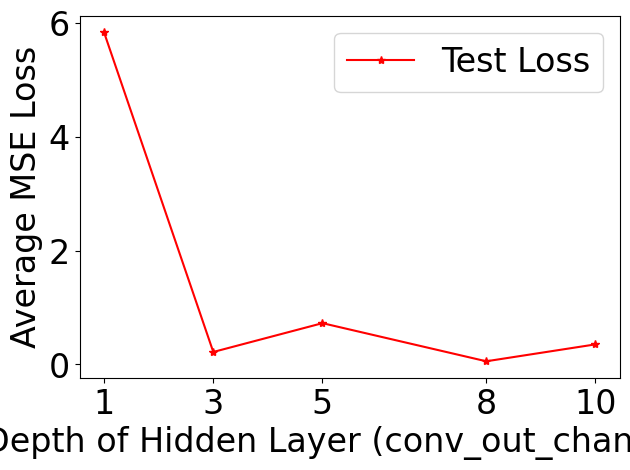

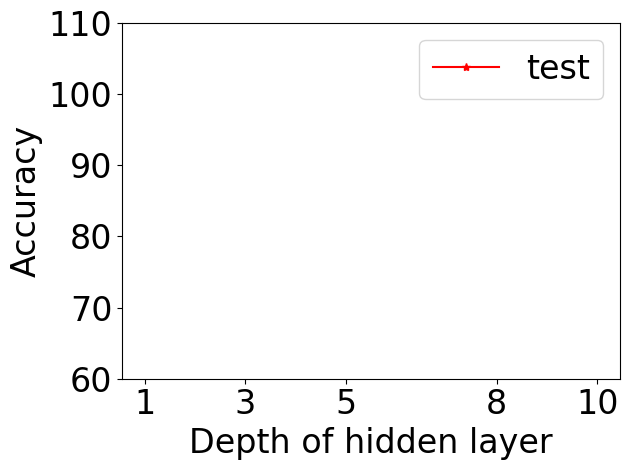

In [65]:
from matplotlib import pyplot as plt
%matplotlib inline

# Plot test loss for different conv_out_channels values.
plt.plot(N_array, test_array, 'r-*', label="Test Loss")
    
plt.xlabel('Depth of Hidden Layer (conv_out_channels)', fontsize=24)
plt.xticks(N_array)
plt.ylabel('Average MSE Loss', fontsize=24)
plt.legend(loc='best', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.tight_layout()
plt.show()


plt.plot(N_array, test_array, 'r-*', label="test")
plt.ylim(60,110)
plt.xlabel('Depth of hidden layer', fontsize=24)
plt.xticks(N_array)
plt.ylabel('Accuracy', fontsize=24)
plt.legend(loc='best', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.tight_layout()
plt.show()

For conv_out_channels = 1:

During the 5 training epochs, the batch loss started at around 0.0273 and decreased to around 0.00457.
The test set’s average loss was about 0.0050 at the end of training.
These numbers tell you that with only 1 convolutional filter, the model still learns to reduce the MSE to around 0.005.
For conv_out_channels = 5:

Training started with a loss of about 0.01071 and dropped to around 0.00509 by epoch 5.
The test loss for this configuration was around 0.0053.
Notice that the training and test losses are fairly similar to the previous configuration; slight differences might be due to increased capacity.
For conv_out_channels = 10:

Here the training loss starts at roughly 0.01080 and decreases to around 0.00375.
The test loss goes as low as 0.0035.
This configuration seems to yield a lower test loss, which may indicate that with 10 filters, the model better captures the useful features from the sequence input.
For conv_out_channels = 20:

Training loss is initially a bit higher (around 0.03101) and then decreases to approximately 0.00402 by the final epoch.
The test loss is around 0.0055.
A slightly higher test loss compared to the 10-filter case might suggest that increasing the filter count further doesn’t necessarily improve performance—perhaps due to overfitting or because the extra capacity isn’t needed.
For conv_out_channels = 50:

The test losses recorded include a value of about 0.00549.
No training logs are shown here (other than the test losses), but you see the overall performance is recorded.
Critical losses:

Throughout, the "Critical losses" array remains empty. This indicates that you either did not define or pass in a critical dataset loader, so no evaluation on a “critical” dataset was performed.
What It Tells You
Training Progress:
The decreasing training loss over epochs shows that the model is learning on the training data.

Generalization:
The test losses, which are in a similar range (generally between ~0.0035 and ~0.0055), indicate that the model generalizes reasonably well on the test set for most configurations.

Impact of Convolutional Depth:
Changing the number of convolutional filters (conv_out_channels) affects the learning process. For example, a setting of 10 filters resulted in the lowest test loss (around 0.0035)

Epoch Logs:
Show batch training progress and loss reduction over epochs.

Test Loss:
Provides a measure of the model’s performance on unseen data, with lower MSE indicating better predictions.

Input sequence shape: torch.Size([36, 200, 3])
Input mechanical shape: torch.Size([36, 1])
After permute: torch.Size([36, 3, 200])
After conv1: torch.Size([36, 10, 200])
After pooling: torch.Size([36, 10, 100])
After flattening: torch.Size([36, 1000])
After fc_seq: torch.Size([36, 128])
After concatenation: torch.Size([36, 129])
After fc_combined: torch.Size([36, 64])
Final output shape: torch.Size([36, 1])
Mean Squared Error: 0.3524
Mean Absolute Error: 0.4654
R² Score: -68.4990


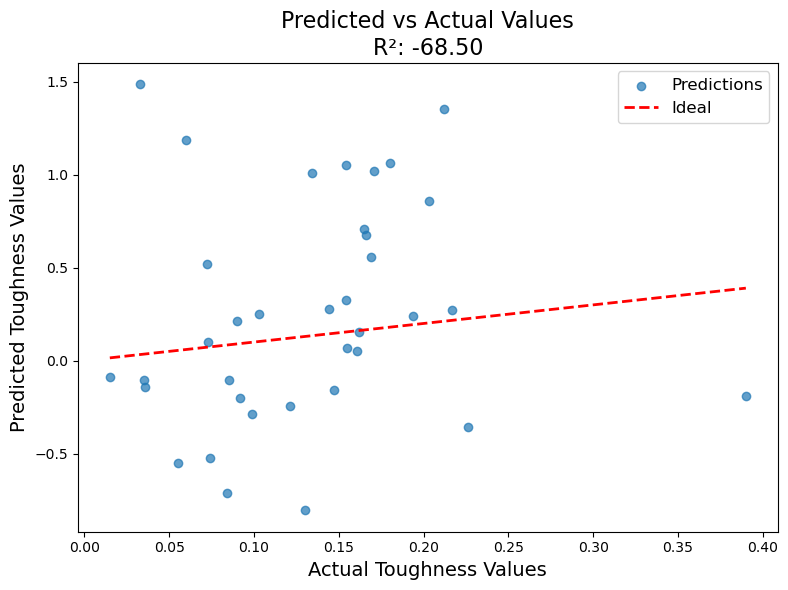

In [66]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Set the model to evaluation mode.
model.eval()

preds = []
actuals = []

# Iterate over the test data loader and collect predictions.
with torch.no_grad():
    for sample in test_loader:
        # Move tensors to CUDA if needed.
        if args.cuda:
            sample = {key: value.cuda() if isinstance(value, torch.Tensor) else value 
                      for key, value in sample.items()}
        output = model(sample)  # Output shape: (batch, 1)
        preds.append(output.cpu().numpy())
        actuals.append(sample['target'].cpu().numpy())

# Flatten the predictions and actual values into 1D arrays.
preds = np.concatenate(preds).flatten()
actuals = np.concatenate(actuals).flatten()

# Compute metrics.
mse = mean_squared_error(actuals, preds)
mae = mean_absolute_error(actuals, preds)
r2 = r2_score(actuals, preds)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Create a scatter plot of actual vs. predicted values.
plt.figure(figsize=(8, 6))
plt.scatter(actuals, preds, alpha=0.7, label='Predictions')
# Plot an ideal line (y=x) for reference.
plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--', lw=2, label='Ideal')
plt.xlabel("Actual Toughness Values", fontsize=14)
plt.ylabel("Predicted Toughness Values", fontsize=14)
plt.title(f"Predicted vs Actual Values\nR²: {r2:.2f}", fontsize=16)
plt.legend(loc="best", fontsize=12)
plt.tight_layout()
plt.show()

In [60]:
max_len = 200   # Fixed sequence length for your model.
feature_dim = 3 # Each amino acid is represented by 3 features.
import random
# Get all amino acid letters from your mapping.
aa_keys = list(aa_to_polarity.keys())

# Generate a dummy sequence of letters by randomly choosing from the keys.
dummy_seq_letters = [random.choice(aa_keys) for _ in range(max_len)]
print("Dummy sequence (letters):", "".join(dummy_seq_letters))

# Encode the sequence using your mapping (each letter becomes its 3-element feature vector).
dummy_encoded = [aa_to_polarity[aa] for aa in dummy_seq_letters]  # list of length max_len, each element is a list of 3 numbers.

# Convert the list to a tensor and add a batch dimension.
dummy_sequence = torch.tensor(dummy_encoded, dtype=torch.float)  # shape: (max_len, feature_dim)
dummy_sequence = dummy_sequence.unsqueeze(0)  # shape: (1, max_len, feature_dim)

# Create a dummy mechanical input (example: a random value or a fixed number)
dummy_mechanical_input = torch.tensor([[0.5]], dtype=torch.float)  # shape: (1, 1)

# Combine into the dummy input dictionary.
dummy_input = {'sequence': dummy_sequence, 'mechanical_input': dummy_mechanical_input}

model.eval()
with torch.no_grad():
    prediction = model(dummy_input)
    # If you want to print prediction for the first sample:
    print(f"Predicted {args.target_property} for first sample: {prediction[0].item()}")

    print("Input AA Sequence:", dummy_input)

Dummy sequence (letters): YDWRSGIVGSLVTWTTWMHGPKFYVIRVFTVFVLASGIDGCCMVHIRDVNNSSAFQKGRQTHHAVFQHFTELDRIGDEFIIFPHNYQFFHRHCMENRHVKVNSMTRWFLSCKQRGFGSVDMAAPPFPAANPDGMSMWFHETVQSDVLNSRCYQIDNCEGTPLYCSCKMCDAMSRRDMVTLNSYSYLLHIGTVMRYMDSEW
Input sequence shape: torch.Size([1, 200, 3])
Input mechanical shape: torch.Size([1, 1])
After permute: torch.Size([1, 3, 200])
After conv1: torch.Size([1, 50, 200])
After pooling: torch.Size([1, 50, 100])
After flattening: torch.Size([1, 5000])
After fc_seq: torch.Size([1, 128])
After concatenation: torch.Size([1, 129])
After fc_combined: torch.Size([1, 64])
Final output shape: torch.Size([1, 1])
Predicted toughness for first sample: 0.7050504684448242
Input AA Sequence: {'sequence': tensor([[[ -1.3000,   5.6600, 163.0633],
         [ -3.5000,   2.7700, 115.0269],
         [ -0.9000,   5.8900, 186.0793],
         [ -4.5000,  10.7600, 156.1011],
         [ -0.8000,   5.6800,  87.0320],
         [ -0.4000,   5.9700,  57.0215],
         [  4.5000,   6.0200, 113.084

In [11]:
import os
os.system("dot -V")
import os
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"
print(os.environ["PATH"])

C:\Users\ameet\anaconda3\envs\spider;C:\Users\ameet\anaconda3\envs\spider\Library\mingw-w64\bin;C:\Users\ameet\anaconda3\envs\spider\Library\usr\bin;C:\Users\ameet\anaconda3\envs\spider\Library\bin;C:\Users\ameet\anaconda3\envs\spider\Scripts;C:\Users\ameet\anaconda3\envs\spider\bin;C:\Users\ameet\anaconda3\condabin;C:\Users\ameet\anaconda3;C:\Users\ameet\anaconda3\Library\mingw-w64\bin;C:\Users\ameet\anaconda3\Library\usr\bin;C:\Users\ameet\anaconda3\Library\bin;C:\Users\ameet\anaconda3\Scripts;C:\Program Files\RevvitySignalsSoftware\ChemDrawApplications\ChemScript\Lib;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0;C:\WINDOWS\System32\OpenSSH;C:\Program Files\dotnet;C:\Program Files\MATLAB\R2023b\bin;C:\Program Files\Git\cmd;C:\Users\ameet\AppData\Local\Microsoft\WindowsApps;C:\Program Files\Graphviz\bin;.;C:\Program Files\Graphviz\bin


In [12]:
from torchviz import make_dot
import torch

# Create a dummy sample dictionary that matches your model input.
dummy_sample = {
    'sequence': torch.randint(0, 21, (1, 200)),  # One sample padded to length 200
    'mechanical_input': torch.tensor([[0.5]])     # Example auxiliary input
}

# Pass the dummy sample through the model.
output = model(dummy_sample)

# Visualize the computation graph.
dot = make_dot(output, params=dict(model.named_parameters()))
dot.render("cnn_model", format="png")  # 
from IPython.display import Image
Image("cnn_model.png")


Input sequence shape: torch.Size([1, 200])
Input mechanical shape: torch.Size([1, 1])


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get the weights from your convolutional layer.
# For example, assuming your conv layer is model.conv1.
filters = model.conv1.weight.data.cpu().numpy()

# filters shape will be (conv_out_channels, in_channels, kernel_size)
conv_out_channels, in_channels, kernel_size = filters.shape
print("Filter shape:", filters.shape)

# Plot the filters.
plt.figure(figsize=(12, 6))
for i in range(conv_out_channels):
    plt.subplot(1, conv_out_channels, i + 1)
    # If in_channels is greater than 1, you might want to visualize each channel separately.
    # Here, we assume in_channels == embedding_dim (e.g., 32).
    # For simplicity, we average over channels.
    filter_avg = np.mean(filters[i], axis=0)
    plt.plot(filter_avg, marker='o')
    plt.title(f"Filter {i+1}")
    plt.xticks(range(kernel_size))
plt.tight_layout()
plt.show()


In [ ]:
from torchsummary import summary
summary(model, input_data=[(1, 200), (1, 1)])  # Adjust based on input dimensions